In [1]:
! source ../venv/bin/activate

In [2]:
! which python

/Users/JMECKEL/development/projects/python/udacity_boarding_kiosk/venv/bin/python


In [3]:
import sys
print(sys.executable)

/Users/JMECKEL/development/projects/python/udacity_boarding_kiosk/venv/bin/python


In [4]:
import uuid
from azure.ai.documentintelligence import DocumentIntelligenceAdministrationClient
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import (
    DocumentBuildMode,
    BuildDocumentModelRequest,
    AzureBlobContentSource,
    DocumentModelDetails,
    AnalyzeResult,
)
from azure.core.credentials import AzureKeyCredential

from azure.storage.blob import ContainerClient
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

In [5]:
load_dotenv(dotenv_path="../.env", override=True)

AZURE_DOC_INTEL_ENDPOINT = os.getenv("AZURE_DOC_INTEL_ENDPOINT")
AZURE_DOC_INTEL_KEY = os.getenv("AZURE_DOC_INTEL_KEY")
AZURE_BLOB_BP_TRAINING_DATA_URL = os.getenv("AZURE_BLOB_BP_TRAINING_DATA_URL")

In [6]:
!ls -al ../starter/boarding_pass_template/

total 1432
drwxr-xr-x@ 10 JMECKEL  staff     320 Jul 15 15:14 .
drwxr-xr-x@ 20 JMECKEL  staff     640 Jul 15 15:28 ..
-rw-r--r--@  1 JMECKEL  staff   35277 Jul 15 15:14 boarding_pass_template.docx
-rw-r--r--@  1 JMECKEL  staff  116384 Jul 15 15:14 boarding_pass_template.pdf
-rw-r--r--@  1 JMECKEL  staff   94851 Jul 15 15:14 boarding-avkash.pdf
-rw-r--r--@  1 JMECKEL  staff   94718 Jul 15 15:14 boarding-james-webb.pdf
-rw-r--r--@  1 JMECKEL  staff   94115 Jul 15 15:14 boarding-james.pdf
-rw-r--r--@  1 JMECKEL  staff   94842 Jul 15 15:14 boarding-libby.pdf
-rw-r--r--@  1 JMECKEL  staff   93823 Jul 15 15:14 boarding-radha-s-kumar.pdf
-rw-r--r--@  1 JMECKEL  staff   93262 Jul 15 15:14 boarding-sameer.pdf


In [7]:
endpoint = AZURE_DOC_INTEL_ENDPOINT
key = AZURE_DOC_INTEL_KEY
training_data_url = AZURE_BLOB_BP_TRAINING_DATA_URL

In [9]:
document_intelligence_admin_client = DocumentIntelligenceAdministrationClient(endpoint, AzureKeyCredential(key))
poller = document_intelligence_admin_client.begin_build_document_model(
    BuildDocumentModelRequest(
        model_id=str(uuid.uuid4()),
        build_mode=DocumentBuildMode.TEMPLATE,
        azure_blob_source=AzureBlobContentSource(container_url=training_data_url),
        description="boarding_pass_custom_model",
    )
)
model: DocumentModelDetails = poller.result()

In [10]:
print(f"Model ID: {model.model_id}")
print(f"Description: {model.description}")
print(f"Model created on: {model.created_date_time}")
print(f"Model expires on: {model.expiration_date_time}")

Model ID: c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6
Description: boarding_pass_custom_model
Model created on: 2025-07-17 07:40:37+00:00
Model expires on: 2027-07-17 07:40:37+00:00


In [11]:
if model.doc_types:
    print("Doc types the model can recognize:")
    for name, doc_type in model.doc_types.items():
        print(f"Doc Type: '{name}' built with '{doc_type.build_mode}' mode which has the following fields:")
        if doc_type.field_schema:
            for field_name, field in doc_type.field_schema.items():
                if doc_type.field_confidence:
                    print(
                        f"Field: '{field_name}' has type '{field['type']}' and confidence score "
                        f"{doc_type.field_confidence[field_name]}"
                    )

Doc types the model can recognize:
Doc Type: 'c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6' built with 'DocumentBuildMode.TEMPLATE' mode which has the following fields:
Field: 'FirstName' has type 'string' and confidence score 0.995
Field: 'LastName' has type 'string' and confidence score 0.995
Field: 'From' has type 'string' and confidence score 0.995
Field: 'To' has type 'string' and confidence score 0.995
Field: 'Gate' has type 'string' and confidence score 0.995
Field: 'BoardingTime' has type 'string' and confidence score 0.995
Field: 'FlightNo' has type 'string' and confidence score 0.995
Field: 'SeatNo' has type 'string' and confidence score 0.995


In [12]:
container_client = ContainerClient.from_container_url(training_data_url)

In [13]:
print("Blobs in container:")
for blob in container_client.list_blobs():
    print(blob.name)

Blobs in container:
boarding-avkash.pdf
boarding-avkash.pdf.labels.json
boarding-avkash.pdf.ocr.json
boarding-james.pdf
boarding-james.pdf.labels.json
boarding-james.pdf.ocr.json
boarding-libby.pdf
boarding-libby.pdf.labels.json
boarding-libby.pdf.ocr.json
boarding-radha-s-kumar.pdf
boarding-radha-s-kumar.pdf.labels.json
boarding-radha-s-kumar.pdf.ocr.json
boarding-sameer.pdf
boarding-sameer.pdf.labels.json
boarding-sameer.pdf.ocr.json
fields.json


In [14]:
input_boarding_pass = "../starter/boarding_pass_template/boarding-james-webb.pdf"

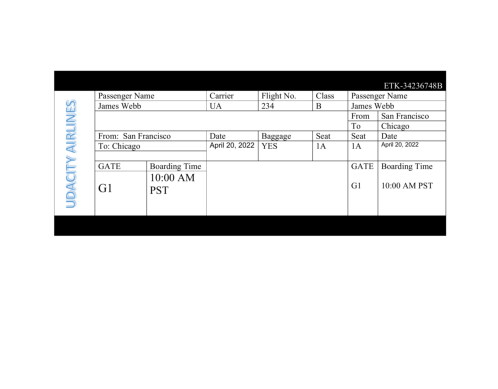

In [15]:
pages = convert_from_path(input_boarding_pass, dpi=200)
plt.figure()
plt.imshow(pages[0])
plt.axis('off')
plt.show()

In [16]:
document_intelligence_client = DocumentIntelligenceClient(endpoint=endpoint, credential=AzureKeyCredential(key))

In [17]:
with open(input_boarding_pass, "rb") as f:
    poller = document_intelligence_client.begin_analyze_document(model_id=model.model_id, body=f)
labeled_custom_test_action_result: AnalyzeResult = poller.result()

In [18]:
def _print_table(header_names, table_data):
    # Print a two-dimensional array like a table.
    max_len_list = []
    for i in range(len(header_names)):
        col_values = list(map(lambda row: len(str(row[i])), table_data))
        col_values.append(len(str(header_names[i])))
        max_len_list.append(max(col_values))

    row_format_str = "".join(map(lambda len: f"{{:<{len + 4}}}", max_len_list))

    print(row_format_str.format(*header_names))
    for row in table_data:
        print(row_format_str.format(*row))

In [19]:
if labeled_custom_test_action_result.documents:
    for idx, document in enumerate(labeled_custom_test_action_result.documents):
        print(f"--------Analyzing document #{idx + 1}--------")
        print(f"Document has type {document.doc_type}")
        print(f"Document has document type confidence {document.confidence}")
        print(f"Document was analyzed with model with ID {labeled_custom_test_action_result.model_id}")
        if document.fields:
            for name, field in document.fields.items():
                field_value = field.get("valueString") if field.get("valueString") else field.content
                print(
                    f"......found field of type '{field.type}' with value '{field_value}' and with confidence {field.confidence}"
                )

    # Extract table cell values
    SYMBOL_OF_TABLE_TYPE = "array"
    SYMBOL_OF_OBJECT_TYPE = "object"
    KEY_OF_VALUE_OBJECT = "valueObject"
    KEY_OF_CELL_CONTENT = "content"

    for doc in labeled_custom_test_action_result.documents:
        if not doc.fields is None:
            for field_name, field_value in doc.fields.items():
                # Dynamic Table cell information store as array in document field.
                if field_value.type == SYMBOL_OF_TABLE_TYPE and field_value.value_array:
                    col_names = []
                    sample_obj = field_value.value_array[0]
                    if KEY_OF_VALUE_OBJECT in sample_obj:
                        col_names = list(sample_obj[KEY_OF_VALUE_OBJECT].keys())
                    print("----Extracting Dynamic Table Cell Values----")
                    table_rows = []
                    for obj in field_value.value_array:
                        if KEY_OF_VALUE_OBJECT in obj:
                            value_obj = obj[KEY_OF_VALUE_OBJECT]
                            extract_value_by_col_name = lambda key: (
                                value_obj[key].get(KEY_OF_CELL_CONTENT)
                                if key in value_obj and KEY_OF_CELL_CONTENT in value_obj[key]
                                else "None"
                            )
                            row_data = list(map(extract_value_by_col_name, col_names))
                            table_rows.append(row_data)
                    _print_table(col_names, table_rows)

                elif (
                    field_value.type == SYMBOL_OF_OBJECT_TYPE
                    and KEY_OF_VALUE_OBJECT in field_value
                    and field_value[KEY_OF_VALUE_OBJECT] is not None
                ):
                    rows_by_columns = list(field_value[KEY_OF_VALUE_OBJECT].values())
                    is_fixed_table = all(
                        (
                            rows_of_column["type"] == SYMBOL_OF_OBJECT_TYPE
                            and Counter(list(rows_by_columns[0][KEY_OF_VALUE_OBJECT].keys()))
                            == Counter(list(rows_of_column[KEY_OF_VALUE_OBJECT].keys()))
                        )
                        for rows_of_column in rows_by_columns
                    )

                    # Fixed Table cell information store as object in document field.
                    if is_fixed_table:
                        print("----Extracting Fixed Table Cell Values----")
                        col_names = list(field_value[KEY_OF_VALUE_OBJECT].keys())
                        row_dict: dict = {}
                        for rows_of_column in rows_by_columns:
                            rows = rows_of_column[KEY_OF_VALUE_OBJECT]
                            for row_key in list(rows.keys()):
                                if row_key in row_dict:
                                    row_dict[row_key].append(rows[row_key].get(KEY_OF_CELL_CONTENT))
                                else:
                                    row_dict[row_key] = [
                                        row_key,
                                        rows[row_key].get(KEY_OF_CELL_CONTENT),
                                    ]

                        col_names.insert(0, "")
                        _print_table(col_names, list(row_dict.values()))

print("------------------------------------")

--------Analyzing document #1--------
Document has type c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6:c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6
Document has document type confidence 0.989
Document was analyzed with model with ID c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6
......found field of type 'DocumentFieldType.STRING' with value '10:00 AM PST' and with confidence 0.99
......found field of type 'DocumentFieldType.STRING' with value '1A' and with confidence 0.973
......found field of type 'DocumentFieldType.STRING' with value 'Chicago' and with confidence 0.99
......found field of type 'DocumentFieldType.STRING' with value '234' and with confidence 0.99
......found field of type 'DocumentFieldType.STRING' with value 'G1' and with confidence 0.99
......found field of type 'DocumentFieldType.STRING' with value 'James' and with confidence 0.995
......found field of type 'DocumentFieldType.STRING' with value 'Webb' and with confidence 0.995
......found field of type 'DocumentFieldType.STRING' with value 'S

In [20]:
labeled_custom_test_action_result

{'apiVersion': '2024-11-30', 'modelId': 'c019b05b-8db9-4c65-b0d4-f0f2b21e7ff6', 'stringIndexType': 'textElements', 'content': 'ETK-34236748B\nUDACITY AIRLINES\nPassenger Name\nCarrier\nFlight No.\nClass\nPassenger Name\nJames Webb\nUA\n234\nB\nJames Webb\nFrom\nSan Francisco\nTo\nChicago\nFrom: San Francisco\nDate\nBaggage\nSeat\nSeat\nDate\nTo: Chicago\nApril 20, 2022\nYES\n1A\n1A\nApril 20, 2022\nGATE\nBoarding Time\nGATE\nBoarding Time\nG1\n10:00 AM\nG1\n10:00 AM PST\nPST', 'pages': [{'pageNumber': 1, 'angle': 0.052027568221092224, 'width': 11, 'height': 8.5, 'unit': 'inch', 'words': [{'content': 'ETK-34236748B', 'polygon': [8.5691, 1.6801, 9.9371, 1.676, 9.9371, 1.8483, 8.5702, 1.8483], 'confidence': 0.992, 'span': {'offset': 0, 'length': 13}}, {'content': 'UDACITY', 'polygon': [1.2567, 4.5863, 1.2567, 3.4028, 1.5405, 3.403, 1.5429, 4.5883], 'confidence': 0.994, 'span': {'offset': 14, 'length': 7}}, {'content': 'AIRLINES', 'polygon': [1.2567, 3.3185, 1.2567, 2.0641, 1.5345, 2.0641,

In [21]:
fields = labeled_custom_test_action_result.documents[0].fields if labeled_custom_test_action_result.documents else {}
print(fields)
first_name = fields.get("FirstName").get("valueString") if (fields.get("FirstName") and fields.get("FirstName").get("valueString")) else None
last_name = fields.get("LastName").get("valueString") if (fields.get("LastName") and fields.get("LastName").get("valueString")) else None
start = fields.get("From").get("valueString") if (fields.get("From") and fields.get("From").get("valueString")) else None
dest = fields.get("To").get("valueString") if (fields.get("To") and fields.get("To").get("valueString")) else None
gate = fields.get("Gate").get("valueString") if (fields.get("Gate") and fields.get("Gate").get("valueString")) else None
bt = fields.get("BoardingTime").get("valueString") if (fields.get("BoardingTime") and fields.get("BoardingTime").get("valueString")) else None
fno = fields.get("FlightNo").get("valueString") if (fields.get("FlightNo") and fields.get("FlightNo").get("valueString")) else None
sno = fields.get("SeatNo").get("valueString") if (fields.get("SeatNo") and fields.get("SeatNo").get("valueString")) else None

print(f"Name: {first_name} {last_name}")
print(f"From {start} to {dest}")
print(f"Gate: {gate}")
print(f"Boarding Time: {bt}")
print(f"FlightNo: {fno}")
print(f"SeatNo: {sno}")


{'BoardingTime': {'type': 'string', 'valueString': '10:00 AM PST', 'content': '10:00 AM\nPST', 'boundingRegions': [{'pageNumber': 1, 'polygon': [3.195, 3.77, 4.265, 3.77, 4.265, 4.26, 3.195, 4.26]}], 'confidence': 0.99, 'spans': [{'offset': 288, 'length': 8}, {'offset': 313, 'length': 3}]}, 'SeatNo': {'type': 'string', 'valueString': '1A', 'content': '1A', 'boundingRegions': [{'pageNumber': 1, 'polygon': [7.025, 3.07, 7.27, 3.07, 7.27, 3.23, 7.025, 3.23]}], 'confidence': 0.973, 'spans': [{'offset': 226, 'length': 2}]}, 'To': {'type': 'string', 'valueString': 'Chicago', 'content': 'Chicago', 'boundingRegions': [{'pageNumber': 1, 'polygon': [2.345, 3.065, 3, 3.065, 3, 3.26, 2.345, 3.26]}], 'confidence': 0.99, 'spans': [{'offset': 199, 'length': 7}]}, 'FlightNo': {'type': 'string', 'valueString': '234', 'content': '234', 'boundingRegions': [{'pageNumber': 1, 'polygon': [5.765, 2.145, 6.075, 2.145, 6.075, 2.305, 5.765, 2.305]}], 'confidence': 0.99, 'spans': [{'offset': 100, 'length': 3}]},